<a href="https://colab.research.google.com/github/sujitkoley9/TIme-Series-Forcasting/blob/master/Time_Series_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages



In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import read_csv
import numpy as np
from collections import OrderedDict 
from datetime import datetime
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt

from pyramid.arima import auto_arima


# for deep learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout


# Reading file

In [0]:
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"],format='%Y-%m')
df.index= df["Month"]
df.drop(['Month'], axis=1,inplace= True)



# Time series  different component

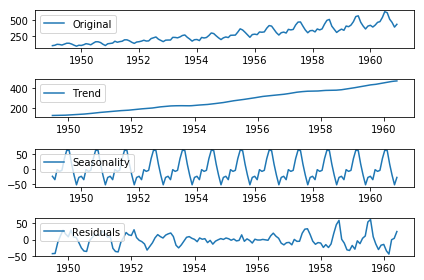

In [140]:

decomposition = seasonal_decompose(df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

# Check Stationarity of a Time Series

A TS is said to be stationary if its statistical properties such as mean, variance and co-variance  remain constant over time


**There are 2 major reasons behind non-stationaruty of a TS:**
- Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
-  Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.


**So, more formally, we can check stationarity using the following:**

- Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

- Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [0]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

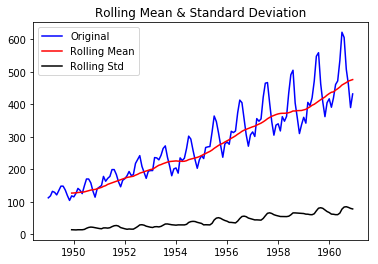

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [142]:
test_stationarity(df["#Passengers"])

# Splitting train and text

In [0]:
Train_TS = df[:130]
Test_TS = df[130:]

Result_stat_list=[]


# Method 1 :  Naive method

Many a times we are provided with a dataset, which is stable throughout it’s time period. If we want to forecast the price for the next day, we can simply take the last day value and estimate the same value for the next day. Such forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.


![alt text](https://raw.githubusercontent.com/sujitkoley9/TIme-Series-Forcasting/Image/Images/Naive_1.png)

In [0]:
Test_TS["Predicted_Naive"] = Train_TS.ix[(len(Train_TS) -1),"#Passengers"]


**Compare using plot**

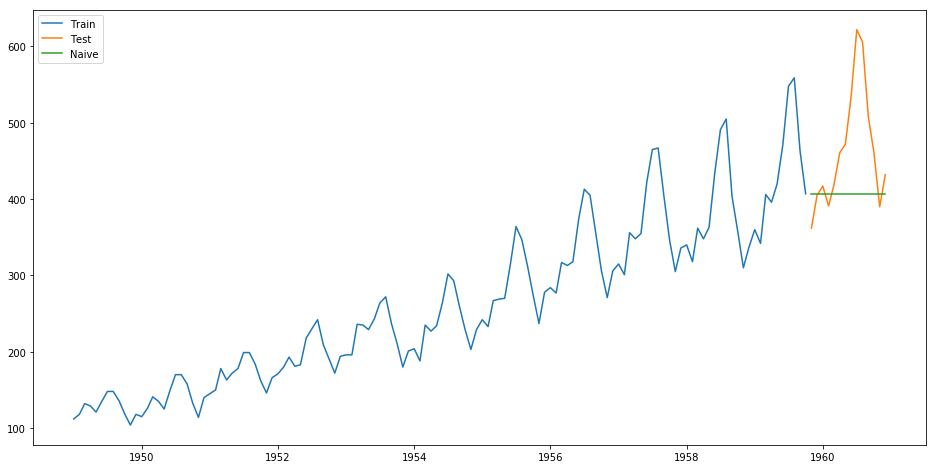

In [145]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Predicted_Naive"], label='Naive')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [146]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Predicted_Naive"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "Naive"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)
print(rmse)

94.83481880165563


# Method 2 : Simple average

Many a times we are provided with a dataset, which though varies by a small margin throughout it’s time period, but the average at each time period remains constant. In such a case we can forecast the price of the next day somewhere similar to the average of all the past days.

Such forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

![alt text](https://raw.githubusercontent.com/sujitkoley9/TIme-Series-Forcasting/Image/Images/Simple%20average.png)

In [0]:
Test_TS["Predicted_SimpleAverage"] = Train_TS["#Passengers"].mean()


**Compare using plot**

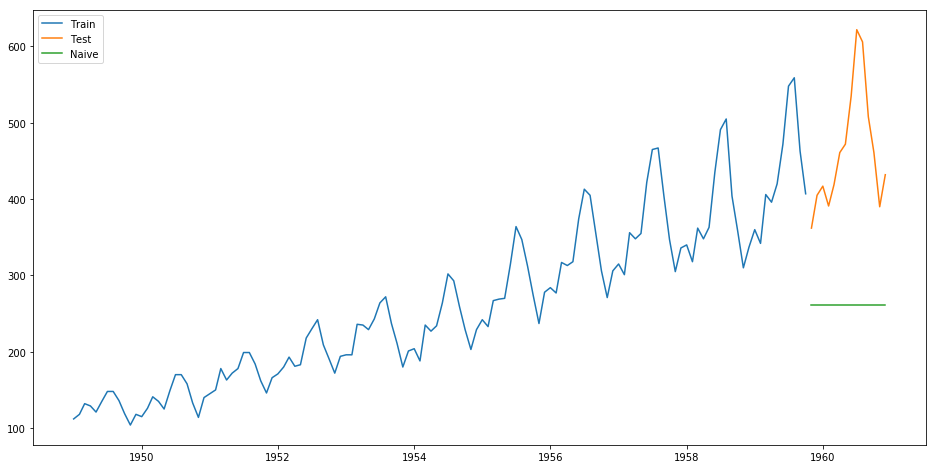

In [148]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Predicted_SimpleAverage"], label='Naive')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [149]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Predicted_SimpleAverage"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "Simple Average"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)
print(rmse)

216.31005184494583


# Method 3 : Moving avearage

Many a times we are provided with a dataset, in which the prices/sales of the object increased/decreased sharply some time periods ago. In order to use the  previous Average method, we have to use the mean of all the previous data, but using all the previous data doesn’t sound right.

Using the prices of the initial period would highly affect the forecast for the next period. Therefore as an improvement over simple average, we will take the average of the prices for last few time periods only. Obviously the thinking here is that only the recent values matter. Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

Using a simple moving average model, we forecast the next value(s) in a time series based on the average of a fixed finite number ‘p’ of the previous values. Thus, for all i > p

![alt text](https://raw.githubusercontent.com/sujitkoley9/TIme-Series-Forcasting/Image/Images/Simple%20Moving%20Average.png)

In [0]:
Test_TS["Predicted_MovingAverage"] = Train_TS["#Passengers"].rolling(60).mean()[-1]


**Compare using plot**

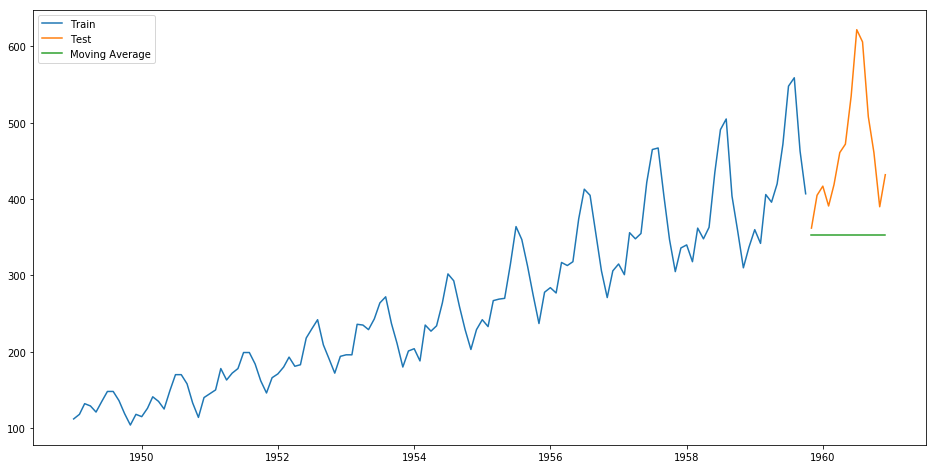

In [151]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Predicted_MovingAverage"], label='Moving Average')
plt.legend(loc='best')
plt.show()

***Checking RMSE score***

In [152]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Predicted_MovingAverage"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "Moving Average"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)

print(rmse)

134.45638270162686


# Method 4 : Simple exponential smoothing

After we have understood the above methods, we can note that both Simple average and Weighted moving average lie on completely opposite ends. We would need something between these two extremes approaches which takes into account all the data while weighing the data points differently. For example it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

![alt text](https://raw.githubusercontent.com/sujitkoley9/TIme-Series-Forcasting/Image/Images/Simple%20Exponential%20Smoothing.png)

where 0≤ α ≤1 is the smoothing parameter.

In [0]:
Model = SimpleExpSmoothing(Train_TS["#Passengers"])

Result_SimpleExponentialSmoothing = Model.fit(smoothing_level=0.6,optimized=True)

Test_TS["Predicted_SimpleExponentialSmoothing"] = Result_SimpleExponentialSmoothing.forecast(len(Test_TS))

**Compare using plot**

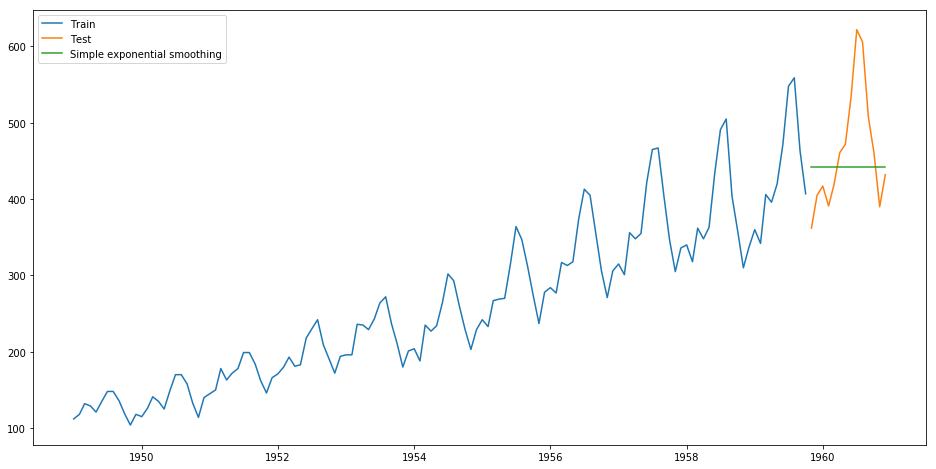

In [154]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Predicted_SimpleExponentialSmoothing"], label='Simple exponential smoothing')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [155]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Predicted_SimpleExponentialSmoothing"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "Simple Exponential Smoothing"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)

print(rmse)

79.54045779320737


# Method 5. Holt’s Linear Trend

Holt extended simple exponential smoothing to allow forecasting of data with a trend. It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend. To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected forecast ŷ

![alt text](https://raw.githubusercontent.com/sujitkoley9/TIme-Series-Forcasting/Image/Images/Holt%E2%80%99s%20Linear%20Trend.png)

The values we predicted in the above algorithms are called Level. In the above three equations, you can notice that we have added level and trend to generate the forecast equation.

In [0]:
Model = Holt(Train_TS["#Passengers"])

Result_Holt_linear = Model.fit(smoothing_level = 0.3,smoothing_slope = 0.1)

Test_TS["Predicted_HoltLinearTrend"] = Result_Holt_linear.forecast(len(Test_TS))

**Compare using plot**

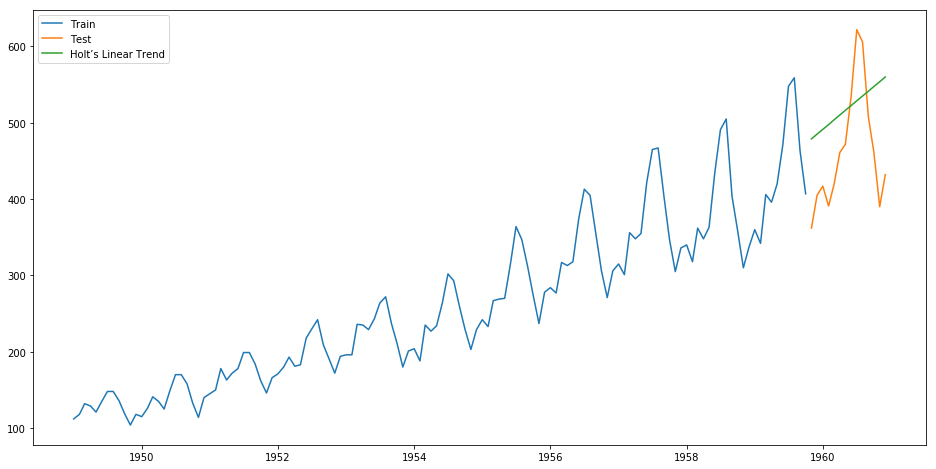

In [157]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Predicted_HoltLinearTrend"], label='Holt’s Linear Trend')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [158]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Predicted_HoltLinearTrend"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "Holt Linear Trend"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)

print(rmse)

90.34888752326782


# Method 6: Holt-Winters

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices. One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

Using Holt’s winter method will be the best option among the rest of the models beacuse of the seasonality factor. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.


![alt text](https://raw.githubusercontent.com/sujitkoley9/TIme-Series-Forcasting/Image/Images/Holt-Winters.png)

In [0]:
Model = ExponentialSmoothing(Train_TS["#Passengers"],seasonal_periods=12 ,trend='add', seasonal='add')

Result_Holt_winter = Model.fit()

Test_TS["Predicted_HoltWinters"] = Result_Holt_winter.forecast(len(Test_TS))



**Compare using plot**

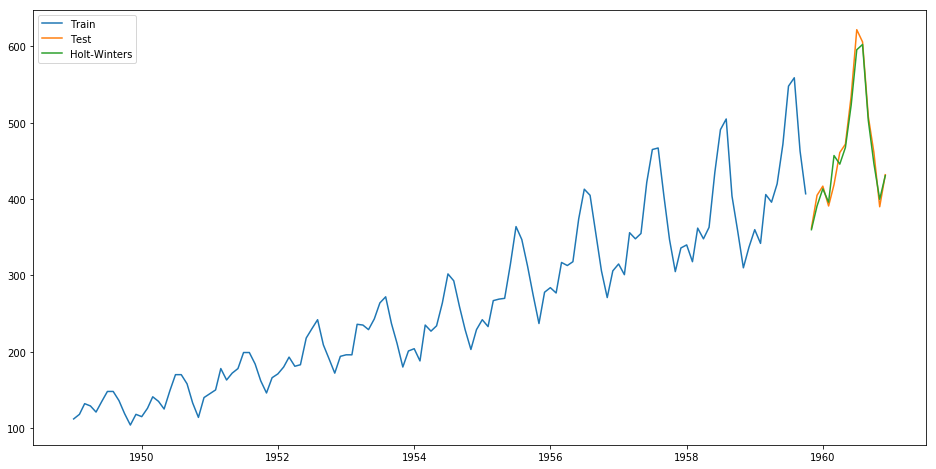

In [160]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Predicted_HoltWinters"], label='Holt-Winters')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [161]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Predicted_HoltWinters"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "Holt's Winters"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)


print(rmse)

14.912513714758031


#  Method 7 : Arima model


The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

   -  Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
   -  Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
   - Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

- Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In [0]:
Train_TS_log = np.log(Train_TS)
Train_TS_log_diff = Train_TS_log - Train_TS_log.shift()
Train_TS_log_diff.dropna(inplace=True)





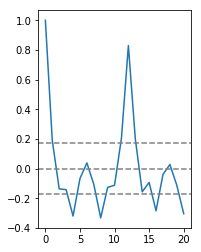

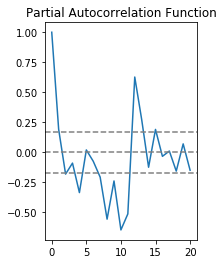

In [163]:


lag_acf = acf(Train_TS_log_diff, nlags=20)
lag_pacf = pacf(Train_TS_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Train_TS_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Train_TS_log_diff)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Train_TS_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Train_TS_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
#plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.


 **Parameter tuning for ARIMA method**

In [0]:
stepwise_fit = auto_arima(Train_TS_log, start_p=1, start_q=1, max_p=3, max_q=3, 
                          #start_P=1, start_Q=1, max_P=3, max_Q=3,
                          #m=12 ,# mean monthly data
                          seasonal=False,
                          d=1, 
                          #D=1, 
                          trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise


stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-218.201, BIC=-206.762, Fit time=0.106 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-209.050, BIC=-203.330, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-211.755, BIC=-203.176, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-213.673, BIC=-205.094, Fit time=0.025 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-242.866, BIC=-228.567, Fit time=0.227 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-213.897, BIC=-202.458, Fit time=0.047 seconds


**Fit ARIMA model**

In [0]:
model = ARIMA(Train_TS_log, order=(3, 1, 3), freq=Train_TS_log.index.inferred_freq)  
results_AR = model.fit(disp=-1)  

predictions_ARIMA_log = results_AR.forecast(len(Test_TS))[0]

predictions_ARIMA = np.exp(predictions_ARIMA_log)

Test_TS["Prediction_ARIMA"] = predictions_ARIMA





**Comapare using plot**

In [0]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.plot(Test_TS["Prediction_ARIMA"], label='SARIMA')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [0]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Prediction_ARIMA"]))


Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "ARIMA"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)

print(rmse)

# Method 8 : SARIMAX

**Parameter tuning for SARIMAX**

In [0]:
stepwise_fit_SARIMAX = auto_arima(Train_TS_log, start_p=1, start_q=1, max_p=3, max_q=3, 
                          start_P=1, start_Q=1, max_P=3, max_Q=3,
                          m=12 ,# mean monthly data
                          seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise


stepwise_fit_SARIMAX.summary()

**Fit SARIMAX model**

In [0]:
model = SARIMAX(Train_TS_log, order=(0, 1, 1),seasonal_order=(0,1,1,12),freq=Train_TS_log.index.inferred_freq)

Result_SARIMAX = model.fit(disp=-1)


predictions_SARIMAX_log = Result_SARIMAX.get_forecast(len(Test_TS))

Lower_confidence = np.exp(predictions_SARIMAX_log.conf_int().iloc[:,0])
Upper_confidence = np.exp(predictions_SARIMAX_log.conf_int().iloc[:,1])

Test_TS["Prediction_SARIMAX"] = np.exp(predictions_SARIMAX_log.predicted_mean)



**Comapare using plot**

In [0]:
plt.figure(figsize=(16,8))
plt.plot(Train_TS["#Passengers"], label='Train')
plt.plot(Test_TS["#Passengers"], label='Test')
plt.fill_between(Lower_confidence.index,Lower_confidence,Upper_confidence,color='k',alpha=.2)
plt.plot(Test_TS["Prediction_SARIMAX"], label='SARIMAX')
plt.legend(loc='best')
plt.show()

**Checking RMSE score**

In [0]:
rmse = sqrt(mean_squared_error(Test_TS["#Passengers"], Test_TS["Prediction_SARIMAX"]))

Result_stat_dict =  OrderedDict()
Result_stat_dict["Method"] = "SARIMA"
Result_stat_dict["RMSE"] = rmse

Result_stat_list.append(Result_stat_dict)

print(rmse)


# Method 9 : Using Deep learning

In [0]:
# Fuction to prepare LSTM data set
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
Train_TS_Array = Train_TS["#Passengers"].values
Test_TS_Array = Test_TS["#Passengers"].values

Train_TS_Array = Train_TS_Array.reshape(-1,1)
Test_TS_Array  =  Test_TS_Array.reshape(-1,1)



In [0]:
#-----Scaling
sc = StandardScaler()
Train_TS_Array = sc.fit_transform(Train_TS_Array)
Test_TS_Array = sc.transform(Test_TS_Array)


In [0]:
# reshape into X=t and Y=t+1, timestep 5
look_back = 5
trainX, trainY = create_dataset(Train_TS_Array, look_back)
testX, testY = create_dataset(Test_TS_Array, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])


In [0]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=240, verbose=False)


In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([trainY])
testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([testY])

In [0]:
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Comparision between different methods

In [0]:
 Result_stat_df= pd.DataFrame.from_dict(Result_stat_list)


In [0]:
plt.figure(figsize=(18,8))
sns_plot = sns.barplot(x="Method", y="RMSE", data=Result_stat_df)

sns_plot.set_xticklabels(sns_plot.get_xticklabels(),rotation=-10)
sns_plot.set_title('Comparision between different methods')